In [2]:

import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction import DictVectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

import nltk
import string

import re

pd.options.display.max_rows = 5
import nltk
from nltk.corpus import stopwords

In [3]:
def add_beer_class(df):
    remove = string.punctuation
    remove = remove.replace("-", "")
    pattern = "[{}]".format(remove)

    df.description = df.description.str.lower()
    df.description = df.description.str.replace(pattern,"")
    df.description = df.description.str.replace("\d","")

    beers = ["light","pale","hop","stout","porter","lager","malt","amber","blonde ale",
        "sweet","bitter","fruit","dark","ale","ipa","double","wheat","beer"]
    for beer_type in beers:
        text = "{0}[^ ]*".format(beer_type)
        df[beer_type] = df["description"].str.contains(text,
                                                       regex=True,
                                                       flags=re.IGNORECASE)
    return df


wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc,arg = None):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc)
    doc = doc.replace("\r","")
    doc = doc.replace("\n","")
    doc = doc.replace("-"," ")
    doc = doc.replace("'","")
    doc = doc.lower()
    doc = doc.strip()
    tokens = wpt.tokenize(doc)
    filtered_tokens = [token for token in tokens if token not in stop_words]

    if arg == "bigrams":
        return get_bigrams(filtered_tokens)
    if arg == "trigrams":
        return get_trigrams(filtered_tokens)
    doc = ' '.join(filtered_tokens)
    return doc

def top_words(df, quant, mode = "greater",description = True):
    if description:
        df["description"] = df["description"].apply(normalize_document)
        filter_on = "description"
    else:
        df["name"] = df["name"].apply(normalize_document)
        filter_on = "name"
    if mode == "greater":
        words = df[df["ibu"] > df["ibu"].quantile(quant)][filter_on].apply(nltk.word_tokenize)
    elif mode == "less":
        words = df[df["ibu"] < df["ibu"].quantile(quant)][filter_on].apply(nltk.word_tokenize)
    else:
        words = df[filter_on].apply(nltk.word_tokenize)
    print(words)
    sep_words = words.apply(pd.Series).melt()["value"]
    return sep_words.dropna().value_counts()

def get_trigrams(words):
    return list(zip(words[:-2], words[1:-1],words[2:]))

def get_quadgrams(words):
    return list(zip(words[:-2], words[1:-1],words[2:],words[3:]))

def get_bigrams(words):
    return list(zip(words[:-2], words[1:-1]))

In [6]:
df = pd.read_csv("/Users/ramanyakkala/Downloads/beer_train.csv")
df_test = pd.read_csv("/Users/ramanyakkala/Downloads/beer_test.csv")
df.head()

,id,abv,available,description,glass,ibu,isOrganic,name,originalGravity,srm
0,0,8.2,"Available at the same time of year, every year.",A Belgian-Abbey-Style Tripel that is big in al...,NaN,31.0,N,LoonyToonTripel,1.070,8
1,1,5.7,"Available at the same time of year, every year.",Covert Hops is a crafty ale. Its stealthy dark...,Pint,45.0,N,Covert Hops,1.056,35
2,2,5.8,"Available at the same time of year, every year.",This is a traditional German-style Marzen char...,Mug,25.0,N,Oktoberfest,1.048,10
3,3,5.5,Available year round as a staple beer.,A West Coast-Style Pale Ale balancing plenty o...,Pint,55.0,N,Pale Ale,1.044,5
4,4,4.8,Available year round as a staple beer.,This Bombshell has a tantalizing crisp and cle...,Pint,11.4,N,Head Turner Blonde Ale,1.045,3


In [7]:
df["description"] = df["description"].fillna("Missing")
df_test["description"] = df_test["description"].fillna("Missing")
df_test["ibu"] = df["ibu"].astype(int)

In [8]:
top_big_ibu = top_words(df,0.75)
top_small_ibu = top_words(df,0.50,"less")
top_very_small_ibu = top_words(df,0.10,"less")

5       [first, brewed, black, lightning, name, implie...
9       [newest, addition, harvest, family, southern, ...
                              ...                        
5986    [velvety, chewy, ipa, perfect, blend, hop, bit...
5987    [took, pale, ale, added, summit, cascade, hops...
Name: description, Length: 1484, dtype: object
0       [belgianabbeystyle, tripel, big, alcohol, even...
2       [traditional, germanstyle, marzen, characteriz...
                              ...                        
5996    [barley, wine, would, considered, englishstyle...
5999                                            [missing]
Name: description, Length: 2939, dtype: object
4       [bombshell, tantalizing, crisp, clean, flavor,...
13      [take, traditional, irish, ale, beer, lightbod...
                              ...                        
5983    [plaid, ferret, low, bitterness, beer, malt, h...
5989    [made, homegrown, strawberries, poteet, texas,...
Name: description, Length: 469, dtyp

In [9]:
top_very_big_ibu = top_words(df,0.90)

43      [belgian, tripel, grain, bill, black, malt, ad...
59      [many, hops, many, times, smooth, crisp, malt,...
                              ...                        
5969    [supertonic, scale, note, one, step, tonic, sc...
5987    [took, pale, ale, added, summit, cascade, hops...
Name: description, Length: 598, dtype: object


In [10]:
top_big_ibu.head()

hops    1048
ipa      958
hop      864
beer     827
malt     546
Name: value, dtype: int64

In [11]:
top_small_ibu.head()

beer      2271
ale       1624
malt      1059
hops       878
brewed     773
Name: value, dtype: int64

In [12]:
top_very_small_ibu.head()

beer      431
wheat     257
ale       234
brewed    138
light     134
Name: value, dtype: int64

In [13]:
top_small = pd.DataFrame(top_big_ibu).merge(pd.DataFrame(top_small_ibu),how='outer',left_index=True, right_index=True)
top_small = top_small.fillna(0)
top_small["per_x"] = top_small["value_x"]/top_small["value_x"].sum()
top_small["per_y"] = top_small["value_y"]/top_small["value_y"].sum()
top_small["diff"] = top_small["value_x"] - top_small["value_y"]
top_small["per_diff"] = top_small["per_x"] - top_small["per_y"]
top_small.sort_values("per_diff",ascending=False)

,value_x,value_y,per_x,per_y,diff,per_diff
ipa,958.0,13.0,0.019559,0.000141,945.0,0.019418
hop,864.0,488.0,0.017640,0.005275,376.0,0.012365
...,...,...,...,...,...,...
ale,546.0,1624.0,0.011147,0.017554,-1078.0,-0.006407
beer,827.0,2271.0,0.016884,0.024548,-1444.0,-0.007663


In [14]:
top_small = pd.DataFrame(top_very_big_ibu).merge(pd.DataFrame(top_small_ibu),how='outer',left_index=True, right_index=True)
top_small = top_small.fillna(0)
top_small["per_x"] = top_small["value_x"]/top_small["value_x"].sum()
top_small["per_y"] = top_small["value_y"]/top_small["value_y"].sum()
top_small["diff"] = top_small["value_x"] - top_small["value_y"]
top_small["per_diff"] = top_small["per_x"] - top_small["per_y"]

In [15]:
top_small.sort_values("per_diff",ascending=False).index

Index(['ipa', 'hop', 'hops', 'double', 'imperial', 'big', 'citrus', 'india',
       'hopped', 'cascade',
       ...
       'traditional', 'crisp', 'yeast', 'german', 'refreshing', 'lager',
       'light', 'wheat', 'ale', 'beer'],
      dtype='object', length=13434)

In [16]:
top_small.sort_values("per_diff",ascending=False).index

Index(['ipa', 'hop', 'hops', 'double', 'imperial', 'big', 'citrus', 'india',
       'hopped', 'cascade',
       ...
       'traditional', 'crisp', 'yeast', 'german', 'refreshing', 'lager',
       'light', 'wheat', 'ale', 'beer'],
      dtype='object', length=13434)

In [17]:
bigram_big = (df[df["ibu"] > df["ibu"].quantile(0.75)]["description"].
              apply(lambda x :normalize_document(x,"bigrams")).
              apply(pd.Series).melt()["value"])
bigram_small = (df[df["ibu"] < df["ibu"].quantile(0.50)]["description"].
              apply(lambda x :normalize_document(x,"bigrams")).
              apply(pd.Series).melt()["value"])
bigram_very_big = (df[df["ibu"] > df["ibu"].quantile(0.85)]["description"].
              apply(lambda x :normalize_document(x,"bigrams")).
              apply(pd.Series).melt()["value"])
bigram_very_small = (df[df["ibu"] < df["ibu"].quantile(0.20)]["description"].
              apply(lambda x :normalize_document(x,"bigrams")).
              apply(pd.Series).melt()["value"])

In [21]:
(df[df["ibu"] > df["ibu"].quantile(0.75)]["description"].
              apply(lambda x :normalize_document(x,"bigrams"))).apply(pd.Series)

,0,1,2,3,4,5,6,7,8,9,...,231,232,233,234,235,236,237,238,239,240
5,"(first, brewed)","(brewed, black)","(black, lightning)","(lightning, name)","(name, implies)","(implies, combining)","(combining, style)","(style, defining)","(defining, characteristics)","(characteristics, dark)",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,"(newest, addition)","(addition, harvest)","(harvest, family)","(family, southern)","(southern, hemisphere)","(hemisphere, harvest)","(harvest, first)","(first, time)","(time, know)","(know, american)",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5986,"(velvety, chewy)","(chewy, ipa)","(ipa, perfect)","(perfect, blend)","(blend, hop)","(hop, bitterness)","(bitterness, aroma)","(aroma, malt)","(malt, body)","(body, centennial)",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5987,"(took, pale)","(pale, ale)","(ale, added)","(added, summit)","(summit, cascade)","(cascade, hops)","(hops, throughout)","(throughout, boil)","(boil, provide)","(provide, citrus)",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
bigram_top_big = bigram_big.dropna().value_counts()
bigram_top_very_big = bigram_very_big.dropna().value_counts()

In [111]:
bigram_top_small = bigram_small.dropna().value_counts()
bigram_top_very_small = bigram_very_small.dropna().value_counts()

In [112]:
top_small = pd.DataFrame(bigram_top_big).merge(pd.DataFrame(bigram_top_small),how='outer',left_index=True, right_index=True)
top_small = top_small.fillna(0)
top_small["per_x"] = top_small["value_x"]/top_small["value_x"].sum()
top_small["per_y"] = top_small["value_y"]/top_small["value_y"].sum()
top_small["diff"] = top_small["value_x"] - top_small["value_y"]
top_small["per_diff"] = top_small["per_x"] - top_small["per_y"]

In [113]:
top_small.sort_values("diff",ascending=False)

,value_x,value_y,per_x,per_y,diff,per_diff
"(india, pale)",149.0,2.0,0.003229,0.000023,147.0,0.003206
"(double, ipa)",108.0,1.0,0.002340,0.000012,107.0,0.002329
...,...,...,...,...,...,...
"(brown, ale)",10.0,120.0,0.000217,0.001382,-110.0,-0.001165
"(wheat, beer)",4.0,149.0,0.000087,0.001716,-145.0,-0.001629


In [114]:
top_small.sort_values("diff",ascending=False).index

Index([    ('india', 'pale'),     ('double', 'ipa'),       ('pale', 'ale'),
         ('imperial', 'ipa'), ('imperial', 'stout'),     ('west', 'coast'),
           ('ipa', 'brewed'),   ('american', 'ipa'),  ('hop', 'varieties'),
           ('dry', 'hopped'),
       ...
           ('blonde', 'ale'), ('slightly', 'sweet'),  ('easy', 'drinking'),
          ('orange', 'peel'),    ('beer', 'brewed'),     ('noble', 'hops'),
            ('wheat', 'ale'),     ('ale', 'brewed'),      ('brown', 'ale'),
           ('wheat', 'beer')],
      dtype='object', length=89091)

In [115]:
top_small.sort_values("diff",ascending=False).index

Index([    ('india', 'pale'),     ('double', 'ipa'),       ('pale', 'ale'),
         ('imperial', 'ipa'), ('imperial', 'stout'),     ('west', 'coast'),
           ('ipa', 'brewed'),   ('american', 'ipa'),  ('hop', 'varieties'),
           ('dry', 'hopped'),
       ...
           ('blonde', 'ale'), ('slightly', 'sweet'),  ('easy', 'drinking'),
          ('orange', 'peel'),    ('beer', 'brewed'),     ('noble', 'hops'),
            ('wheat', 'ale'),     ('ale', 'brewed'),      ('brown', 'ale'),
           ('wheat', 'beer')],
      dtype='object', length=89091)

In [116]:
top_small.sort_values("per_diff",ascending=False).index

Index([    ('india', 'pale'),       ('pale', 'ale'),     ('double', 'ipa'),
       ('imperial', 'stout'),   ('imperial', 'ipa'),     ('west', 'coast'),
           ('hop', 'flavor'),     ('ipa', 'brewed'),   ('american', 'ipa'),
        ('american', 'hops'),
       ...
       ('slightly', 'sweet'),     ('golden', 'ale'),  ('easy', 'drinking'),
           ('blonde', 'ale'),    ('orange', 'peel'),     ('ale', 'brewed'),
           ('noble', 'hops'),      ('wheat', 'ale'),      ('brown', 'ale'),
           ('wheat', 'beer')],
      dtype='object', length=89091)

In [117]:
top_small.sort_values("per_diff",ascending=False).index

Index([    ('india', 'pale'),       ('pale', 'ale'),     ('double', 'ipa'),
       ('imperial', 'stout'),   ('imperial', 'ipa'),     ('west', 'coast'),
           ('hop', 'flavor'),     ('ipa', 'brewed'),   ('american', 'ipa'),
        ('american', 'hops'),
       ...
       ('slightly', 'sweet'),     ('golden', 'ale'),  ('easy', 'drinking'),
           ('blonde', 'ale'),    ('orange', 'peel'),     ('ale', 'brewed'),
           ('noble', 'hops'),      ('wheat', 'ale'),      ('brown', 'ale'),
           ('wheat', 'beer')],
      dtype='object', length=89091)

In [118]:
top_small.sort_values("per_diff",ascending=False).head()

,value_x,value_y,per_x,per_y,diff,per_diff
"(india, pale)",149.0,2.0,0.003229,0.000023,147.0,0.003206
"(pale, ale)",207.0,134.0,0.004486,0.001543,73.0,0.002943
"(double, ipa)",108.0,1.0,0.002340,0.000012,107.0,0.002329
"(imperial, stout)",70.0,9.0,0.001517,0.000104,61.0,0.001413
"(imperial, ipa)",62.0,0.0,0.001344,0.000000,62.0,0.001344


In [119]:
top_small.sort_values("value_y",ascending=False).head()

,value_x,value_y,per_x,per_y,diff,per_diff
"(wheat, beer)",4.0,149.0,0.000087,0.001716,-145.0,-0.001629
"(ale, brewed)",35.0,138.0,0.000758,0.001589,-103.0,-0.000831
"(pale, ale)",207.0,134.0,0.004486,0.001543,73.0,0.002943
"(brown, ale)",10.0,120.0,0.000217,0.001382,-110.0,-0.001165
"(beer, brewed)",23.0,96.0,0.000498,0.001105,-73.0,-0.000607


In [85]:
trigram_big = (df[df["ibu"] > df["ibu"].quantile(0.75)]["description"].
              apply(lambda x :normalize_document(x,"trigrams")).
              apply(pd.Series).melt()["value"])
trigram_small = (df[df["ibu"] < df["ibu"].quantile(0.50)]["description"].
              apply(lambda x :normalize_document(x,"trigrams")).
              apply(pd.Series).melt()["value"])
trigram_very_big = (df[df["ibu"] > df["ibu"].quantile(0.85)]["description"].
              apply(lambda x :normalize_document(x,"trigrams")).
              apply(pd.Series).melt()["value"])
trigram_very_small = (df[df["ibu"] < df["ibu"].quantile(0.20)]["description"].
              apply(lambda x :normalize_document(x,"trigrams")).
              apply(pd.Series).melt()["value"])

In [86]:
trigram_top_big = trigram_big.dropna().value_counts()
trigram_top_small = trigram_small.dropna().value_counts()

In [87]:
top_small = pd.DataFrame(trigram_top_big).merge(pd.DataFrame(trigram_top_small),how='outer',left_index=True, right_index=True)
top_small = top_small.fillna(0)
top_small["per_x"] = top_small["value_x"]/top_small["value_x"].sum()
top_small["per_y"] = top_small["value_y"]/top_small["value_y"].sum()
top_small["diff"] = top_small["value_x"] - top_small["value_y"]
top_small["per_diff"] = top_small["per_x"] - top_small["per_y"]

In [88]:
top_small.sort_values("diff",ascending=False)

,value_x,value_y,per_x,per_y,diff,per_diff
"(india, pale, ale)",139.0,2.0,0.001811,0.000014,137.0,0.001797
"(ipa, is, a)",44.0,0.0,0.000573,0.000000,44.0,0.000573
...,...,...,...,...,...,...
"(this, beer, is)",66.0,158.0,0.000860,0.001107,-92.0,-0.000247
"(a, hint, of)",30.0,144.0,0.000391,0.001009,-114.0,-0.000618


In [89]:
top_small.sort_values("diff",ascending=False).index

Index([        ('india', 'pale', 'ale'),               ('ipa', 'is', 'a'),
                   ('ipa', 'with', 'a'),        ('citrus', 'and', 'pine'),
                ('ipa', 'is', 'brewed'),            ('this', 'ipa', 'is'),
          ('and', 'centennial', 'hops'),        ('dry', 'hopped', 'with'),
                ('of', 'citrus', 'and'), ('russian', 'imperial', 'stout'),
       ...
                ('with', 'hints', 'of'),              ('this', 'is', 'a'),
                  ('beer', 'with', 'a'),               ('ale', 'is', 'a'),
                   ('a', 'touch', 'of'),             ('ale', 'with', 'a'),
              ('ale', 'brewed', 'with'),         ('is', 'brewed', 'with'),
                 ('this', 'beer', 'is'),              ('a', 'hint', 'of')],
      dtype='object', length=169014)

In [90]:
top_small.sort_values("per_diff",ascending=False).index

Index([        ('india', 'pale', 'ale'),               ('ipa', 'is', 'a'),
             ('flavor', 'and', 'aroma'),             ('ipa', 'with', 'a'),
              ('citrus', 'and', 'pine'),        ('dry', 'hopped', 'with'),
                ('of', 'citrus', 'and'),       ('of', 'american', 'hops'),
                  ('pale', 'ale', 'is'),          ('balanced', 'by', 'a'),
       ...
       ('american', 'beer', 'festival'),    ('great', 'american', 'beer'),
                ('with', 'hints', 'of'),           ('this', 'beer', 'is'),
               ('is', 'brewed', 'with'),               ('ale', 'is', 'a'),
                   ('ale', 'with', 'a'),            ('beer', 'with', 'a'),
              ('ale', 'brewed', 'with'),              ('a', 'hint', 'of')],
      dtype='object', length=169014)

In [84]:
top_small.sort_values("value_y",ascending=False).index

Index([                ('this', 'beer', 'is'),
                          ('a', 'hint', 'of'),
                     ('is', 'brewed', 'with'),
                         ('a', 'touch', 'of'),
                    ('ale', 'brewed', 'with'),
                          ('this', 'is', 'a'),
                           ('ale', 'is', 'a'),
                         ('ale', 'with', 'a'),
                        ('to', 'create', 'a'),
                        ('beer', 'with', 'a'),
       ...
                    ('copy', 'this', 'month'),
                   ('presence', 'abv', 'and'),
       ('character', 'perfectly', 'balanced'),
                 ('hops', 'then', 'delivers'),
                    ('our', 'sour', 'cherry'),
                   ('versions', 'and', 'had'),
                   ('features', 'our', 'own'),
                         ('in', 'fact', 'we'),
                 ('style', 'hopping', 'this'),
                 ('german', 'malt', 'floral')],
      dtype='object', length=116193)

In [447]:
top_small.sort_values("value_x",ascending=False).index

Index([         ('pale', 'ale'),        ('india', 'pale'),
              ('dry', 'hopped'),        ('double', 'ipa'),
              ('hop', 'flavor'),        ('west', 'coast'),
          ('imperial', 'stout'),     ('american', 'hops'),
               ('hop', 'aroma'),     ('malt', 'backbone'),
       ...
            ('longer', 'aging'),         ('one', 'whiff'),
         ('pouring', 'vibrant'),         ('head', 'good'),
         ('subtle', 'addition'),  ('amarillo', 'crystal'),
         ('sweetness', 'helps'),         ('red', 'brick'),
       ('traditional', 'lager'),      ('late', 'hopping')],
      dtype='object', length=5991)

In [43]:
quadgram_big = (df[df["ibu"] > df["ibu"].quantile(0.75)]["description"].
              apply(lambda x :normalize_document(x,"quadgrams")).
              apply(pd.Series).melt()["value"])
quadgram_small = (df[df["ibu"] < df["ibu"].quantile(0.50)]["description"].
              apply(lambda x :normalize_document(x,"quadgrams")).
              apply(pd.Series).melt()["value"])
quadgram_very_big = (df[df["ibu"] > df["ibu"].quantile(0.85)]["description"].
              apply(lambda x :normalize_document(x,"quadgrams")).
              apply(pd.Series).melt()["value"])
quadgram_very_small = (df[df["ibu"] < df["ibu"].quantile(0.20)]["description"].
              apply(lambda x :normalize_document(x,"quadgrams")).
              apply(pd.Series).melt()["value"])

In [44]:
quadgram_top_big = quadgram_big.dropna().value_counts()
quadgram_top_small = quadgram_small.dropna().value_counts()

In [45]:
top_small = pd.DataFrame(quadgram_top_big).merge(pd.DataFrame(quadgram_top_small),how='outer',left_index=True, right_index=True)
top_small = top_small.fillna(0)
top_small["per_x"] = top_small["value_x"]/top_small["value_x"].sum()
top_small["per_y"] = top_small["value_y"]/top_small["value_y"].sum()
top_small["diff"] = top_small["value_x"] - top_small["value_y"]
top_small["per_diff"] = top_small["per_x"] - top_small["per_y"]

In [46]:
top_small.sort_values("diff",ascending=True)

,value_x,value_y,per_x,per_y,diff,per_diff
missing,142.0,222.0,0.095687,0.075536,-80.0,0.020151
perfect beer fall seasonthis beer brewed using local honey clovermead apiaries north aylmer fact honey collected hives near strathroy nearby basswood trees,0.0,2.0,0.000000,0.000681,-2.0,-0.000681
...,...,...,...,...,...,...
awardwinning barleywine boasts dense fruity bouquet intense flavor palate deep reddishbrown color big maltiness superbly balanced wonderfully bittersweet hoppinessmalts two row pale english carmelyeast ale yeastbittering hops chinookfinishing hops cascade centennialdry hops cascade centennial chinook,4.0,0.0,0.002695,0.000000,4.0,0.002695
weve got imperial stout brewed massive amount coffee chocolates caveaged oak bourbon barrels entire year make sure wonderful bourbon undertones come finish makes taste buds squeal delight,4.0,0.0,0.002695,0.000000,4.0,0.002695


In [652]:
top_small.sort_values("diff",ascending=False)

,value_x,value_y,per_x,per_y,diff,per_diff
ipa,502.0,1.0,0.135493,0.000290,501.0,0.135202
imperial,95.0,10.0,0.025641,0.002903,85.0,0.022738
...,...,...,...,...,...,...
wheat,4.0,110.0,0.001080,0.031930,-106.0,-0.030851
ale,140.0,267.0,0.037787,0.077504,-127.0,-0.039717


In [315]:
top_small.sort_values("value_y",ascending=False).head()

,value_x,value_y,per_x,per_y,diff,per_diff
"(great, american, beer, festival)",2.0,39.0,0.000044,0.000452,-37.0,-0.000409
"(medal, winner, world, beer)",1.0,19.0,0.000022,0.000220,-18.0,-0.000199
"(winner, world, beer, championships)",1.0,14.0,0.000022,0.000162,-13.0,-0.000141
"(medal, world, beer, cup)",0.0,13.0,0.000000,0.000151,-13.0,-0.000151
"(medal, great, american, beer)",1.0,13.0,0.000022,0.000151,-12.0,-0.000129


In [316]:
top_small.sort_values("value_x",ascending=False).head()

,value_x,value_y,per_x,per_y,diff,per_diff
"(style, india, pale, ale)",17.0,0.0,0.000371,0.0,17.0,0.000371
"(west, coast, style, ipa)",11.0,0.0,0.000240,0.0,11.0,0.000240
"(pounds, hops, per, barrel)",10.0,0.0,0.000218,0.0,10.0,0.000218
"(india, pale, ale, brewed)",9.0,0.0,0.000197,0.0,9.0,0.000197
"(ipa, india, pale, ale)",9.0,0.0,0.000197,0.0,9.0,0.000197


In [91]:
name_top_greater = top_words(df,0.75,"greater",False)
name_top_less = top_words(df,0.25,"less",False)

In [92]:
top_small = pd.DataFrame(name_top_greater).merge(pd.DataFrame(name_top_less),how='outer',left_index=True, right_index=True)
top_small = top_small.fillna(0)
top_small["per_x"] = top_small["value_x"]/top_small["value_x"].sum()
top_small["per_y"] = top_small["value_y"]/top_small["value_y"].sum()
top_small["diff"] = top_small["value_x"] - top_small["value_y"]
top_small["per_diff"] = top_small["per_x"] - top_small["per_y"]


In [93]:
top_small.sort_values("per_diff",ascending=True)

,value_x,value_y,per_x,per_y,diff,per_diff
ale,140.0,267.0,0.036213,0.075595,-127.0,-0.039381
wheat,4.0,108.0,0.001035,0.030578,-104.0,-0.029543
...,...,...,...,...,...,...
imperial,94.0,10.0,0.024315,0.002831,84.0,0.021483
ipa,500.0,1.0,0.129333,0.000283,499.0,0.129050


In [94]:
top_small.sort_values("diff",ascending=False).iloc[:20]

,value_x,value_y,per_x,per_y,diff,per_diff
ipa,500.0,1.0,0.129333,0.000283,499.0,0.129050
imperial,94.0,10.0,0.024315,0.002831,84.0,0.021483
...,...,...,...,...,...,...
anniversary,11.0,2.0,0.002845,0.000566,9.0,0.002279
hops,8.0,0.0,0.002069,0.000000,8.0,0.002069


In [95]:
top_small.sort_values("diff",ascending=False).iloc[:20].head()

,value_x,value_y,per_x,per_y,diff,per_diff
ipa,500.0,1.0,0.129333,0.000283,499.0,0.129050
imperial,94.0,10.0,0.024315,0.002831,84.0,0.021483
double,67.0,4.0,0.017331,0.001133,63.0,0.016198
black,74.0,14.0,0.019141,0.003964,60.0,0.015177
pale,67.0,10.0,0.017331,0.002831,57.0,0.014499


In [580]:
df[df["ibu"] > df["ibu"].quantile(0.75)][["description"]].values

array([['first brewed black lightning name implies combining style defining characteristics dark beers ipas stormy balance subtle roasted dark malt flavor citrusy floral character northwestern american hops moderately strong alcohol presence abv electrifyingly hoppy finish grab bottle pint hold tight time ride lightning see httpduclawcombeerblack lightningsthashfudivrdpuf'],
       ['newest addition harvest family southern hemisphere harvest first time know american brewer put beer fresh picked hops southern hemisphere inaugural ale debut late april feature fresh pacific hallertau new zealand motueka new zealand southern cross hops new zealand like celebration ale fresh hops beer dried right picked shipped immediately chico brewing retain peak aromatics flavors ensure freshest hops possible went added expense flying hops new zealand chico could brew week picked'],
       ['missing'],
       ...,
       ['javahead based original oatmeal stout boil hot wort passes hopback vessel packed f

In [579]:
df

,id,abv,available,description,glass,ibu,isOrganic,name,originalGravity,srm
0,0,8.2,"Available at the same time of year, every year.",belgian abbey style tripel big alcohol even bi...,NaN,31.0,N,loonytoontripel,1.070,8
1,1,5.7,"Available at the same time of year, every year.",covert hops crafty ale stealthy dark appearanc...,Pint,45.0,N,covert hops,1.056,35
...,...,...,...,...,...,...,...,...,...,...
5998,5998,6.2,Limited availability.,aquarius white ipa combines phenolic estery ch...,NaN,50.0,N,aquarius,1.044,2
5999,5999,5.1,Available year round as a staple beer.,missing,NaN,23.0,N,amber ale,1.048,15


In [582]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [584]:
vec = TfidfVectorizer(norm=False)
vec.fit(df["description"])
X_train = vec.transform(df["description"])
X_train_len = np.sqrt(X_train.multiply(X_train).sum(axis=1))
y_train = df["ibu"]

In [585]:
def predict_spam(new_text):
    # Get the TF-IDF vector for the new text.
    x_new = vec.transform([new_text])[0, :]
    dot = x_new.multiply(X_train).sum(axis=1)
    x_new_len = np.sqrt(x_new.multiply(x_new).sum())
    denom = x_new_len*X_train_len
    cos_similarities = pd.DataFrame(dot / (denom))[0]
    classif = y_train[cos_similarities.sort_values(ascending=False)[:30].index].mean()
    return classif

In [591]:
test = df["description"].apply(predict_spam)


In [597]:
((((df["ibu"] - test)**2).sum())/len(df))**0.5

22.861656519059796

In [598]:
vec = TfidfVectorizer(norm=False)
vec.fit(df["name"])
X_train = vec.transform(df["name"])
X_train_len = np.sqrt(X_train.multiply(X_train).sum(axis=1))
y_train = df["ibu"]

In [599]:
test = df["name"].apply(predict_spam)


In [600]:
((((df["ibu"] - test)**2).sum())/len(df))**0.5

24.344015131231068

In [611]:
predict_spam("russian imperial stout")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


60.965

In [608]:
df["ibu"].mean()

41.1968775

In [613]:
df_test["name"].values

array(['She WILL!', 'Defender American Pale Ale', 'Hazel', ...,
       "General Washington's Tavern Porter", 'Nut Brown Ale', 'Noble Fir'],
      dtype=object)

In [614]:
df.head()

,id,abv,available,description,glass,ibu,isOrganic,name,originalGravity,srm
0,0,8.2,"Available at the same time of year, every year.",belgian abbey style tripel big alcohol even bi...,NaN,31.0,N,loonytoontripel,1.070,8
1,1,5.7,"Available at the same time of year, every year.",covert hops crafty ale stealthy dark appearanc...,Pint,45.0,N,covert hops,1.056,35
2,2,5.8,"Available at the same time of year, every year.",traditional german style marzen characterized ...,Mug,25.0,N,oktoberfest,1.048,10
3,3,5.5,Available year round as a staple beer.,west coast style pale ale balancing plenty hop...,Pint,55.0,N,pale ale,1.044,5
4,4,4.8,Available year round as a staple beer.,bombshell tantalizing crisp clean flavor light...,Pint,11.4,N,head turner blonde ale,1.045,3


In [616]:
df["log_ibu"] = np.log(df["ibu"])

In [623]:
df.pivot_table(index="available",values="ibu").sort_values("ibu")

,ibu
available,
Available during the fall months.,30.403546
Available during the summer months.,30.439623
...,...
Beer is not available.,42.486141
Limited availability.,48.227558


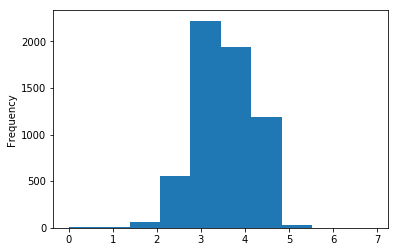

In [618]:
df["log_ibu"].plot.hist()